In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pickle
import sys, os, time

sys.path.append(os.path.abspath("src"))
from slp_model_setup import SegLabel, SLP_Model
from common import linear_ramp_params, get_counts, plot_solutions

In [2]:
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.algorithms import QAOA
from qiskit.algorithms.optimizers import COBYLA

from qiskit import Aer
from qiskit.utils import algorithm_globals, QuantumInstance

## Model

In [3]:
with open("data/hip-dataset.pickle", "rb") as f:
    segLabel = pickle.load(f)

num_nodes = segLabel.num_detections
num_labels = segLabel.num_classes
num_segments = 2  # segLabel.max_num_persons

# alpha_dc
A = segLabel.alphas.copy()
A[A > 100] = 100
# print(A)

# beta_dc_d'c'
B = segLabel.betas.copy()
# B = np.nan_to_num(B, nan=0.0)
# print(B)

model = SLP_Model(num_nodes, num_segments, num_labels, A, B)

In [4]:
# Build the DOcplex model of the S&L problem
mdl = model.build_model(D=100)  # enable constraints
mdl.solve()
mdl.print_information()
mdl.print_solution()

x = np.zeros(mdl.number_of_binary_variables)
for v in mdl.iter_binary_vars():
    x[v.index] = v.solution_value
# print(x)

obj_exact = mdl.objective_value
x_exact = x

Model: Segmentation and Labeling
 - number of variables: 16
   - binary=16, integer=0, continuous=0
 - number of constraints: 0
   - linear=0
 - parameters: defaults
 - objective: minimize quadratic
 - problem type is: MIQP
objective: -2.200
status: OPTIMAL_SOLUTION(2)
  x_0_0_0=1
  x_1_0_1=1
  x_2_1_0=1
  x_3_1_1=1


## QAOA

In [5]:
mdl_qp = from_docplex_mp(mdl)
# print(mdl_qp.prettyprint())

mdl_qubo = QuadraticProgramToQubo().convert(mdl_qp)

qubitOp, offset = mdl_qubo.to_ising()

if True:
    # normalize the Hamiltonian
    w_max = np.max(np.abs(qubitOp.primitive.coeffs))
    qubitOp.primitive.coeffs /= w_max
    offset /= w_max

print("Offset:", offset)
# print("Ising Hamiltonian:\n", str(qubitOp))

Offset: 7.760113076590407


In [6]:
# QUBO matrix info
q2 = mdl_qubo.objective.quadratic.to_dict()
num_qubits = qubitOp.num_qubits
num_q2 = len(q2) - num_qubits
print("Number of quadratic terms: ", num_q2)
print("QUBO matrix sparsity: ", num_q2 / (num_qubits * (num_qubits - 1) * 0.5))

Number of quadratic terms:  72
QUBO matrix sparsity:  0.6


## Initial state

In [7]:
# X mixer initialization
initial_state = QuantumCircuit(qubitOp.num_qubits)
for n in range(qubitOp.num_qubits):
    initial_state.h(n)
# initial_state.draw(fold=150)

## Mixer

In [8]:
# X mixer with modified sign wrt. the default Qiskit's version
mixer = QuantumCircuit(qubitOp.num_qubits)
beta = Parameter("β")
for n in range(qubitOp.num_qubits):
    mixer.rx(-2 * beta, n)
# mixer.draw()

In [9]:
reps = 1

n_shots = 128
n_reads = 1024

seed = 12345
algorithm_globals.random_seed = seed
backend = Aer.get_backend("qasm_simulator")
quantum_instance = QuantumInstance(
    backend, seed_simulator=seed, seed_transpiler=seed, shots=n_shots
)

opt = COBYLA(maxiter=1000, tol=1e-4)

initial_point = linear_ramp_params(reps, slope=0.7)
print("init:", initial_point)

qaoa = QAOA(
    optimizer=opt,
    reps=reps,
    initial_state=initial_state,
    mixer=mixer,
    initial_point=initial_point,
    quantum_instance=quantum_instance,
)

results = qaoa.compute_minimum_eigenvalue(qubitOp)
print(results.optimal_parameters.values())

counts = get_counts(
    qaoa.ansatz,
    list(results.optimal_parameters.values()),
    backend=backend,
    n_shots=n_reads,
    seed=seed,
)

sols = []
for s, p in counts.items():
    x = [int(i) for i in reversed(list(s))]
    obj = mdl_qubo.objective.evaluate(x)
    sols.append({"x": x, "prob": p / n_reads, "obj": obj, "feas": model.is_valid(x)})

lowest_obj_sols = sorted(sols, key=lambda k: k["obj"])
for s in lowest_obj_sols[:4]:
    print(s)

init: [0.35 0.35]
dict_values([0.5109314146918099, 0.4941588437863913])
{'x': [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], 'prob': 0.0029296875, 'obj': -2.2000000000001023, 'feas': True}
{'x': [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0], 'prob': 0.00390625, 'obj': -2.2000000000001023, 'feas': True}
{'x': [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], 'prob': 0.001953125, 'obj': 15.519999999999925, 'feas': True}
{'x': [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0], 'prob': 0.0009765625, 'obj': 93.12999999999988, 'feas': True}


## Surface plot

In [10]:
N1 = 20
N2 = 20
betas = np.linspace(start=-np.pi / 2, stop=np.pi / 2, num=N1)
gammas = np.linspace(start=-np.pi / 2, stop=np.pi / 2, num=N2)

params = list(results.optimal_parameters.values())
qaoa.optimizer._options["maxiter"] = 0

energy = np.zeros((N1, N2))
for i, b in enumerate(betas):
    for j, g in enumerate(gammas):
        params[-2], params[-1] = b, g
        qaoa.initial_point = params
        out = qaoa.compute_minimum_eigenvalue(qubitOp)
        energy[i, j] = out.eigenvalue.real + offset

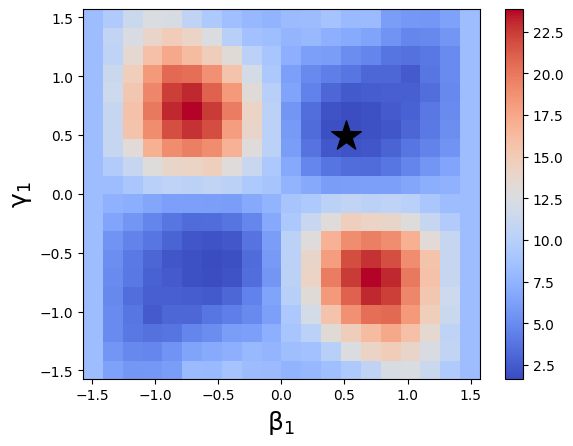

In [11]:
fig, ax = plt.subplots()
im = ax.imshow(
    energy.T,
    interpolation=None,
    origin="lower",
    extent=[betas.min(), betas.max(), gammas.min(), gammas.max()],
    vmax=None,
    aspect="auto",
    cmap="coolwarm",
)
fig.colorbar(im)

params = list(results.optimal_parameters.values())
ax.scatter(params[-2], params[-1], marker="*", s=500, c="black")

ax.set_xlabel(f"β$_{{{reps}}}$", fontsize=18)
ax.set_ylabel(f"γ$_{{{reps}}}$", fontsize=18)
plt.show()